In [1]:
import os

In [2]:
os.listdir('../input/color_data/Train/')    # path to the data

['Color_img']

In [3]:
root = '../input/color_data'

In [4]:
import matplotlib.pyplot as plt
import sys

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable

from torchvision import datasets, transforms, models

In [5]:
import numpy as np
%matplotlib inline

In [6]:

transform = transforms.Compose([transforms.Resize(300),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(root + '/Train', transform=transform)
test_data = datasets.ImageFolder(root + '/Test', transform=transform)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=4)

In [7]:
torch.cuda.is_available()

True

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
def show_img(orig, noisy, denoised):
    fig=plt.figure(figsize=(10,5))
    
    orig = orig.swapaxes(0, 1).swapaxes(1, 2)
    noisy = noisy.swapaxes(0, 1).swapaxes(1, 2)
    denoised = denoised.swapaxes(0, 1).swapaxes(1, 2)
    
    # Normalize for display purpose
    orig     = (orig - orig.min()) / (orig.max() - orig.min())
    noisy    = (noisy - noisy.min()) / (noisy.max() - noisy.min())
    denoised = (denoised - denoised.min()) / (denoised.max() - denoised.min())
    
    fig.add_subplot(1, 3, 1, title='Original')
    plt.imshow(orig)
    
    fig.add_subplot(1, 3, 2, title='Noisy')
    plt.imshow(noisy)
    
    fig.add_subplot(1, 3, 3, title='Denoised')
    plt.imshow(denoised)
    
    fig.subplots_adjust(wspace = 0.5)
    plt.show()


In [10]:
class DAE(nn.Module):
    
    def __init__(self):
    
        super(DAE, self).__init__()
                                                            # 224 x 224 x 3 (input image-noised)
        # Encoder
        self.conv1e = nn.Conv2d(3, 24, 3, padding=2)        
        self.conv2e = nn.Conv2d(24, 48, 3, padding=2)       
        self.conv3e = nn.Conv2d(48, 96, 3, padding=2)       
        self.conv4e = nn.Conv2d(96, 128, 3, padding=2)      
        self.conv5e = nn.Conv2d(128, 256, 3, padding=2)     
        self.mp1e   = nn.MaxPool2d(2, return_indices=True)  

        # Decoder
        self.mp1d = nn.MaxUnpool2d(2)
        self.conv5d = nn.ConvTranspose2d(256, 128, 3, padding=2)
        self.conv4d = nn.ConvTranspose2d(128, 96, 3, padding=2)
        self.conv3d = nn.ConvTranspose2d(96, 48, 3, padding=2)
        self.conv2d = nn.ConvTranspose2d(48, 24, 3, padding=2)
        self.conv1d = nn.ConvTranspose2d(24, 3, 3, padding=2)
        
    
    def forward(self, x):
        # Encoder
        x = self.conv1e(x)
        x = F.relu(x)
        x = self.conv2e(x)
        x = F.relu(x)
        x = self.conv3e(x)
        x = F.relu(x)
        x = self.conv4e(x)
        x = F.relu(x)
        x = self.conv5e(x)
        x = F.relu(x)
        x, i = self.mp1e(x)
        
         # Decoder
        x = self.mp1d(x, i)
        x = self.conv5d(x)
        x = F.relu(x)
        x = self.conv4d(x)
        x = F.relu(x)
        x = self.conv3d(x)
        x = F.relu(x)
        x = self.conv2d(x)
        x = F.relu(x)
        x = self.conv1d(x)
        x = F.relu(x)
        
        return x

In [11]:
noise_level = 0.12

In [12]:
autoencoder = DAE()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.003)

In [13]:
autoencoder.to(device);

Epoch: 1


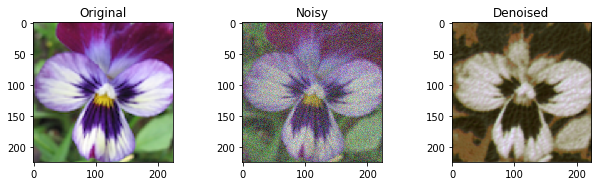

Epoch: 2


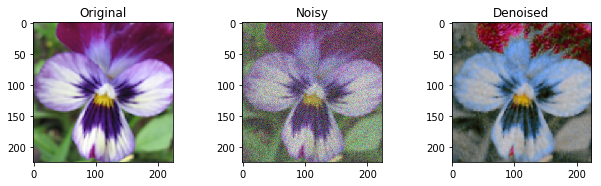

Epoch: 3


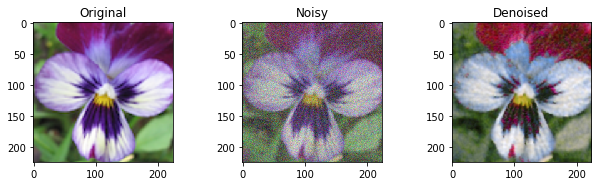

Epoch: 4


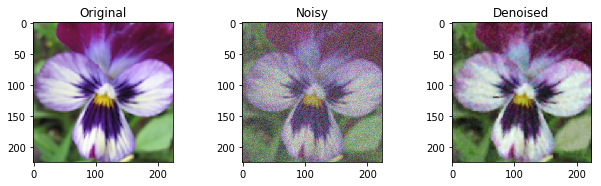

Epoch: 5


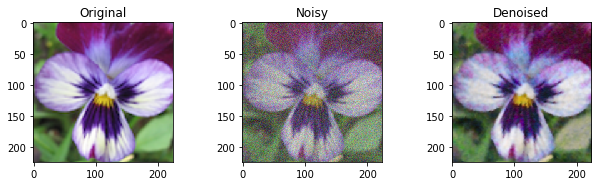

Epoch: 6


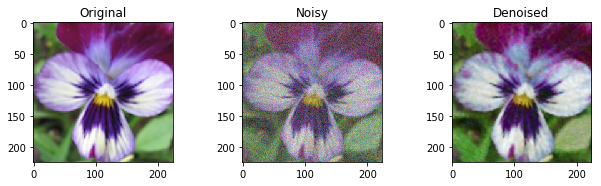

In [14]:
train_loss = []
valid_loss = []

# Training the model 

epochs = 6
#steps = 0


for e in range(epochs):
  running_loss = 0
  running_iter = 0
  for inputs,labels in trainloader:
    noise = torch.randn(inputs.shape[0], 3, 224, 224) * noise_level
    image_n = torch.add(inputs, noise)
    
    image = Variable(inputs).to(device)
    image_n = Variable(image_n).to(device)
    
    optimizer.zero_grad()
    
    output = autoencoder(image_n)
    loss = criterion(output, image)
    loss.backward()              # For gradient calcultion
    optimizer.step()             # Optimizng - Tuning the weights of the model
    
    running_iter +=1
    running_loss += loss.item()
    
    
  autoencoder.eval()
  test_loss = 0
  test_iter = 0
    
  with torch.no_grad():
    for images, labels in testloader:
      noise = torch.randn(images.shape[0], 3, 224, 224) * noise_level
      image_n = torch.add(images, noise)
        
      image = Variable(images).to(device)
      image_n = Variable(image_n).to(device)
        
      output = autoencoder(image_n)
      loss = criterion(output, image)
        
      test_iter +=1
      test_loss += loss.item()
      

  orig = image[0].cpu()
  noisy = image_n[0].cpu()
  denoised = output[0].cpu()

  orig = orig.data.numpy()
  noisy = noisy.data.numpy()
  denoised = denoised.data.numpy()
  print("Epoch:",e+1)
  show_img(orig, noisy, denoised)
  train_loss.append(running_loss / running_iter)
  valid_loss.append(test_loss / test_iter)
        
  running_loss = 0
  autoencoder.train()

In [15]:
torch.save(autoencoder.state_dict(), 'checkpoint_denoising_autoencoder.pth')

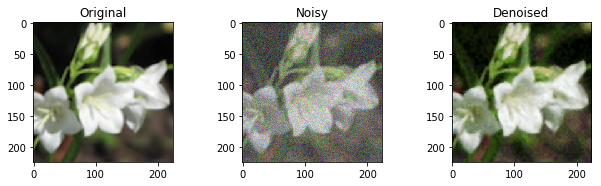

In [16]:
import random

img, _ = random.choice(test_data)
img    = img.resize_((1, 3, 224, 224))
noise  = torch.randn((1, 3, 224, 224)) * noise_level
img_n  = torch.add(img, noise)

img_n = Variable(img_n).cuda()
denoised = autoencoder(img_n)


show_img(img[0].numpy(), img_n[0].data.cpu().numpy(), denoised[0].data.cpu().numpy())